# Munging the LANL netflow set in PySpark

In [1]:
# the full netflow set:

path = "~/data/LANL/"

flowfile = path + "flows.csv"

flows = sc.textFile(flowfile).map(lambda line: [str(x) for x in line.split(',')])
flows.take(10)

[['1', '0', 'C1065', '389', 'C3799', 'N10451', '6', '10', '5323'],
 ['1', '0', 'C1423', 'N1136', 'C1707', 'N1', '6', '5', '847'],
 ['1', '0', 'C1423', 'N1142', 'C1707', 'N1', '6', '5', '847'],
 ['1', '0', 'C14909', 'N8191', 'C5720', '2049', '6', '1', '52'],
 ['1', '0', 'C14909', 'N8192', 'C5720', '2049', '6', '1', '52'],
 ['1', '0', 'C14909', 'N8193', 'C5720', '2049', '6', '1', '52'],
 ['1', '0', 'C1707', 'N1', 'C1423', 'N1136', '6', '4', '414'],
 ['1', '0', 'C1707', 'N1', 'C1423', 'N1142', '6', '4', '413'],
 ['1', '0', 'C1707', 'N1', 'C925', 'N10487', '6', '4', '414'],
 ['1', '0', 'C1707', 'N1', 'C925', 'N10491', '6', '4', '413']]

In [ ]:
# how many flows?

flows.count()

# should be 129,977,412

In [2]:
# restrict to the busiest boxes (listed on file):

import re

bfile = open(path + "bbox.txt")
bbox = set([re.sub('[\"\n]+', "", s) for s in bfile.readlines()])

# index for later use:
box_indices = dict((c, i) for i, c in enumerate(bbox))
indices_box = dict((i, c) for i, c in enumerate(bbox))

# how many distinct?
len(bbox)

10109

In [3]:
# define the flow set we're interested in:

def f(x):
    return [int(x[0]), int(x[1]), x[2], x[3], x[4], x[5], int(x[6]), int(x[7]), int(x[8])]

subflows = flows.filter(lambda f: f[2] in bbox and f[4] in bbox).map(f)

In [76]:
# how many flows in the subset?

subflows.count()

# should be 129,925,366

129925366

In [31]:
# ranges of the integer features:

from __future__ import print_function

duration = subflows.map(lambda x: x[1])
packets = subflows.map(lambda x: x[7])
bytes = subflows.map(lambda x: x[8])

duration.cache()
packets.cache()
bytes.cache()

print("Duration range:", duration.min(), ",", duration.max())
print("Packets range:", packets.min(), ",", packets.max())
print("Bytes range:", bytes.min(), ",", bytes.max())

Duration range: 0 ,  76
Packets range: 1 ,  2471188
Bytes range: 46 ,  2681847376


Let's look at the distributions after log_2 binning:

In [46]:
from math import log, floor

duration_lbin = duration.map(lambda x: int(floor(log(x+1, 2))))
duration_lbin.countByValue()

defaultdict(int,
            {0: 84193649,
             1: 4499644,
             2: 4529776,
             3: 12052081,
             4: 5755560,
             5: 16689791,
             6: 2204865})

In [60]:
packets_lbin = packets.map(lambda x: int(floor(log(x, 2))))
packets_hist = packets_lbin.countByValue()
packets_hist

defaultdict(int,
            {0: 47473242,
             1: 13095984,
             2: 34979596,
             3: 17976228,
             4: 5382553,
             5: 4300465,
             6: 1646712,
             7: 1988773,
             8: 784132,
             9: 747815,
             10: 355620,
             11: 279947,
             12: 337329,
             13: 122359,
             14: 186080,
             15: 213870,
             16: 26972,
             17: 14069,
             18: 7480,
             19: 4687,
             20: 1319,
             21: 134})

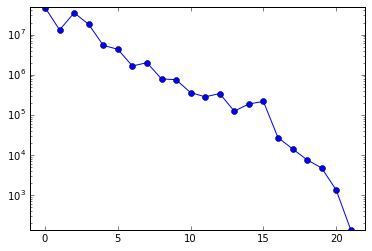

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.semilogy(packets_hist.keys(), packets_hist.values())
plt.stem(packets_hist.keys(), packets_hist.values())
plt.axis([-1,22,0,5e07])
plt.show()

In [49]:
bytes_lbin = bytes.map(lambda x: int(floor(log(x, 2))))
bytes_hist = bytes_lbin.countByValue()
bytes_hist

defaultdict(int,
            {5: 38115544,
             6: 7947117,
             7: 13037956,
             8: 14996109,
             9: 8467179,
             10: 15011644,
             11: 15522943,
             12: 7095295,
             13: 1624686,
             14: 1873248,
             15: 1019176,
             16: 2309768,
             17: 608612,
             18: 995744,
             19: 484181,
             20: 241235,
             21: 111019,
             22: 99893,
             23: 82597,
             24: 40323,
             25: 154630,
             26: 64083,
             27: 10612,
             28: 5327,
             29: 3499,
             30: 2416,
             31: 530})

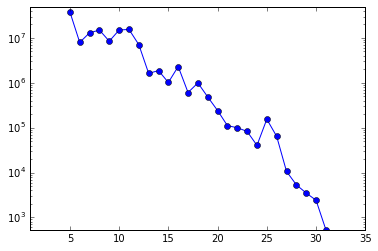

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.semilogy(bytes_hist.keys(), bytes_hist.values())
plt.stem(bytes_hist.keys(), bytes_hist.values())
plt.axis([1,35,0,5e07])
plt.show()

And the protocols:

In [59]:
protocol = subflows.map(lambda x: x[6])
protocol.countByValue()

defaultdict(int, {1: 3316583, 6: 116505060, 17: 10103232, 41: 491})

In [12]:
def normal_port(x, i):
    if re.match('^N', x[i])!=None: 
        return 'N' 
    else: 
        return int(x[i])

src_port = subflows.map(lambda x: normal_port(x,3))
src_port_set = src_port.countByValue()
src_port_set

defaultdict(int,
            {1: 2378,
             7: 872,
             9: 841,
             11: 408,
             13: 870,
             15: 390,
             17: 876,
             18: 384,
             19: 876,
             20: 1424,
             21: 1022,
             22: 262264,
             23: 1005,
             25: 1281,
             37: 868,
             42: 871,
             43: 872,
             49: 874,
             50: 396,
             53: 6406,
             57: 407,
             65: 405,
             67: 398,
             68: 811,
             69: 4,
             70: 856,
             77: 417,
             79: 912,
             80: 3957306,
             87: 391,
             88: 2989193,
             95: 403,
             98: 386,
             101: 374,
             102: 398,
             104: 402,
             105: 399,
             106: 867,
             107: 389,
             109: 872,
             110: 1051,
             111: 233278,
             113: 993,
           

In [13]:
dst_port = subflows.map(lambda x: f(x,5))
dst_port_set = dst_port.countByValue()
dst_port_set

defaultdict(int,
            {1: 2794,
             7: 1631,
             9: 1323,
             11: 666,
             13: 1690,
             15: 653,
             17: 1207,
             18: 661,
             19: 1636,
             20: 1582,
             21: 1488,
             22: 651987,
             23: 1292,
             25: 1746,
             37: 1124,
             42: 1267,
             43: 1280,
             49: 1288,
             50: 640,
             53: 13260,
             57: 639,
             65: 699,
             67: 1110,
             68: 658,
             69: 4395,
             70: 1184,
             77: 553,
             79: 1239,
             80: 4810348,
             87: 635,
             88: 2019214,
             95: 677,
             98: 705,
             101: 715,
             102: 666,
             104: 675,
             105: 738,
             106: 1113,
             107: 690,
             109: 1219,
             110: 1297,
             111: 237166,
             113

In [74]:
# index union of src/dst ports:

portset = set(src_port_set.keys()).union(set(dst_port_set.keys()))
port_indices = dict((c, i) for i, c in enumerate(portset))
indices_port = dict((i, c) for i, c in enumerate(portset))

indices_port

{0: 2049,
 1: 2053,
 2: 1,
 3: 9,
 4: 11,
 5: 13,
 6: 15,
 7: 17,
 8: 18,
 9: 19,
 10: 20,
 11: 21,
 12: 22,
 13: 23,
 14: 25,
 15: 5151,
 16: 37,
 17: 2086,
 18: 42,
 19: 7,
 20: 49,
 21: 50,
 22: 2101,
 23: 2102,
 24: 2103,
 25: 1080,
 26: 2105,
 27: 3130,
 28: 2111,
 29: 65,
 30: 67,
 31: 68,
 32: 1093,
 33: 70,
 34: 2119,
 35: 2121,
 36: 1099,
 37: 77,
 38: 79,
 39: 80,
 40: 5190,
 41: 1109,
 42: 2135,
 43: 88,
 44: 4190,
 45: 95,
 46: 98,
 47: 101,
 48: 5222,
 49: 1127,
 50: 104,
 51: 105,
 52: 106,
 53: 11371,
 54: 109,
 55: 110,
 56: 111,
 57: 113,
 58: 115,
 59: 117,
 60: 119,
 61: 123,
 62: 4224,
 63: 129,
 64: 135,
 65: 137,
 66: 138,
 67: 139,
 68: 143,
 69: 30865,
 70: 5269,
 71: 1178,
 72: 7100,
 73: 161,
 74: 162,
 75: 163,
 76: 164,
 77: 1194,
 78: 174,
 79: 177,
 80: 178,
 81: 179,
 82: 1210,
 83: 5308,
 84: 9418,
 85: 1214,
 86: 191,
 87: 194,
 88: 199,
 89: 201,
 90: 6346,
 91: 6347,
 92: 204,
 93: 546,
 94: 206,
 95: 209,
 96: 210,
 97: 5667,
 98: 1236,
 99: 213,
 10

In [77]:
import json

json.dump(
    {
    'box_indices': box_indices,
    'indices_box': indices_box,
    'port_indices': port_indices,
    'indices_port': indices_port
    },
    open("boxport_data.json", 'w')
)

# Experimenting with a smaller RDD

Let's write to disk, then read in to the session, the small set of protocol 41 flows:

In [126]:
# pull out subset and write to disk:

def toCSVline(data):
  return ','.join(str(d) for d in data)

subflows.filter(lambda x: x[6]==41).map(toCSVline).saveAsTextFile("tmp")

In [5]:
# read from disk to new RDD:

def f(x):
    return [int(x[0]), int(x[1]), x[2], x[3], x[4], x[5], int(x[6]), int(x[7]), int(x[8])]

tmp_rdd = sc.textFile("tmp").map(lambda line: [str(x) for x in line.split(',')]).map(f)
tmp_rdd.take(5)

[[132720, 13, 'C12651', 'N41444', 'C528', 'N41444', 41, 2, 184],
 [134106, 0, 'C12651', 'N16749', 'C528', 'N16749', 41, 1, 92],
 [134465, 0, 'C12651', 'N16749', 'C528', 'N16749', 41, 1, 92],
 [134826, 0, 'C12651', 'N16749', 'C528', 'N16749', 41, 1, 92],
 [135185, 0, 'C12651', 'N16749', 'C528', 'N16749', 41, 1, 92]]

In [6]:
# how many lines?

tmp_rdd.count()

491

In [7]:
# converting computers and ports to binary vectors:

import re

def binary(s):
    if re.match('N', s) != None:
        return [0 for i in range(16)]
    if re.match('C', s) != None:
        s = re.split('C', s)[1]
    x = bin(int(s))
    y = x.split('b')[1]
    while len(y)<16:
        y = '0'+y
    return [int(d) for d in list(y)]

tmp_rdd.map(lambda x: [binary(y) for y in x[2:6]]).take(5)

[[[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 0,

In [8]:
from math import log, floor

def logbin(x):
    return int(floor(log(x, 2)))

def normalise(x):
    return [x[0], logbin(x[1]+1), [binary(z) for z in x[2:6]], x[6], logbin(x[7]), logbin(x[8])]

tmp_rdd.map(normalise).take(2)

[[132720,
  3,
  [[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
  41,
  1,
  7],
 [134106,
  0,
  [[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
  41,
  0,
  6]]

# Generate definitive data set for RNN model

In [4]:
# load box/port info from json:

import json
import re

data = json.load(open("data/boxport_data.json", 'r'))

def jsonIntKeys(x):
    if isinstance(x, dict):
            return {int(k):str(v) for k,v in x.items()}
    return x

def jsonIntVals(x):
    if isinstance(x, dict):
            return {str(k):int(v) for k,v in x.items()}
    return x

box_index = jsonIntVals( data['box_indices'] )
index_box = jsonIntKeys( data['indices_box'] )
port_index = jsonIntVals( data['port_indices'] )
index_port = jsonIntKeys( data['indices_port'] )

bbox = set([re.sub('[\"\n]+', "", s) for s in box_index.keys()])

In [5]:
# define netflow RDD - filter to boxes in 'bbox' (busy computers):

flowfile = path + "flows.csv"
flows = sc.textFile(flowfile).map(lambda line: [str(x) for x in line.split(',')])

def filt(x):
    return [int(x[0]), int(x[1]), x[2], x[3], x[4], x[5], int(x[6]), int(x[7]), int(x[8])]

subflows = flows.filter(lambda f: f[2] in bbox and f[4] in bbox).map(filt)

In [6]:
# define normalisation mapping to be readable in Keras:

from math import log, floor

protocols = [1,6,17,41]
proto_index = dict((c, i) for i, c in enumerate(protocols))
index_proto = dict((i, c) for i, c in enumerate(protocols))

def logbin(x):
    return int(floor(log(x, 2)))

def normal_port(x):
    if re.match('^N', x)!=None: 
        return 'N' 
    else: 
        return x

def normalise(x):
    return [x[0], 
            logbin(x[1]+1),
            box_index[x[2]],
            port_index[normal_port(x[3])],
            box_index[x[4]],
            port_index[normal_port(x[5])],
            proto_index[x[6]], 
            logbin(x[7]), 
            logbin(x[8])]

# check:
subflows.map(normalise).take(10)

[[1, 0, 9501, 138, 2205, 122, 1, 3, 12],
 [1, 0, 2244, 122, 8986, 122, 1, 2, 9],
 [1, 0, 2244, 122, 8986, 122, 1, 2, 9],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 5],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 5],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 5],
 [1, 0, 8986, 122, 2244, 122, 1, 2, 8],
 [1, 0, 8986, 122, 2244, 122, 1, 2, 8],
 [1, 0, 8986, 122, 2408, 122, 1, 2, 8],
 [1, 0, 8986, 122, 2408, 122, 1, 2, 8]]

In [10]:
# write to disk:

def toCSVline(data):
  return ','.join(str(d) for d in data)

subflows.map(normalise).map(toCSVline).saveAsTextFile(path + "flows_for_rnn_model")

#outfile = open(path + "flows_for_rnn_model_100000.csv", 'w')
#output = subflows.map(normalise).map(toCSVline).take(100000)
#for line in output: outfile.write(line + '\n')
#outfile.close()

# Further EDA

In [7]:
normflows = subflows.map(normalise)

normduration = normflows.map(lambda x: x[1])
normduration = normflows.map(lambda x: x[1])
normpackets = normflows.map(lambda x: x[7])
normbytes = normflows.map(lambda x: x[8])

In [12]:
normduration.countByValue()

# should agree with
# {0: 84193649,
#  1: 4499644,
#  2: 4529776,
#  3: 12052081,
#  4: 5755560,
#  5: 16689791,
#  6: 2204865}
# from above.

defaultdict(int,
            {0: 84193649,
             1: 4499644,
             2: 4529776,
             3: 12052081,
             4: 5755560,
             5: 16689791,
             6: 2204865})

In [12]:
# how many src computers are typically seen within 1-sec time bins?

src_process = normflows.map(lambda x: [x[0], x[2]]).groupByKey().cache()

In [ ]:
# histogram of '1-sec sharing':

def f(y):
    return float(len(set(y)))/float(len(y))

h = src_process.sortBy(lambda x: x[0]).map(lambda x : f(list(x[1]))).collect()

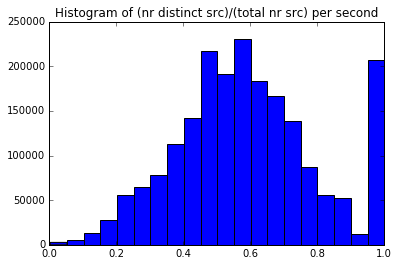

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(h, bins=20)
plt.title("Histogram of (nr distinct src)/(total nr src) per second")
plt.show()

This shows that a typical src computer will appear twice ina typical 1-second time bin. Is this uniform over time? 

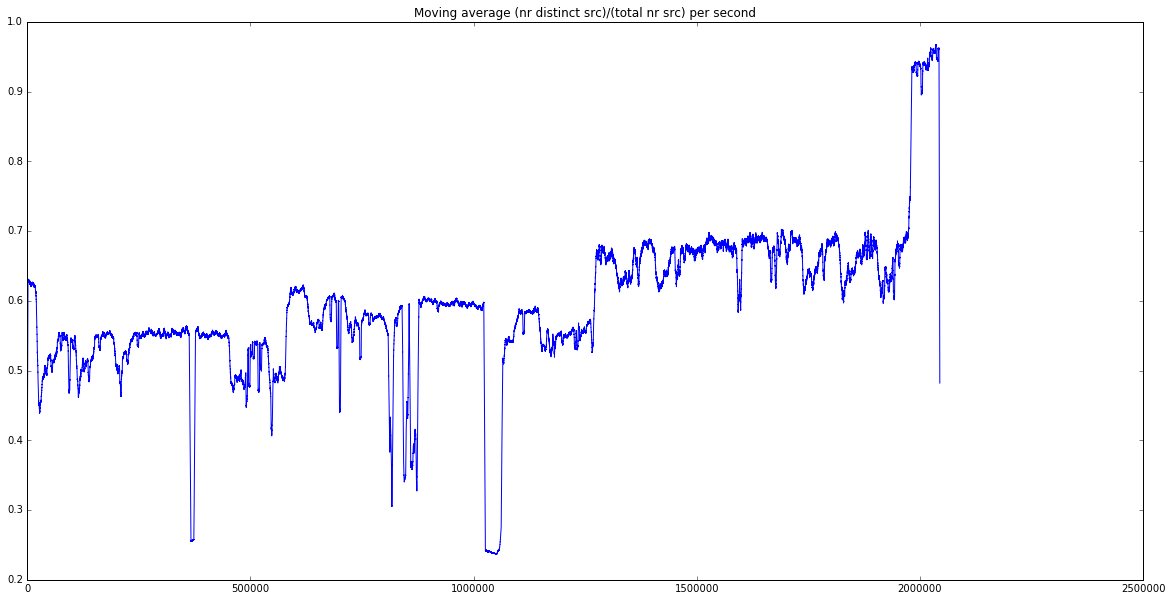

In [61]:
# how does this sharing proportion vary with time?

import numpy as np

def movingaverage(x, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(x, window, 'same')

plt.figure(figsize=(20,10))
plt.plot(movingaverage(h, 3600))
plt.title("Moving average (nr distinct src)/(total nr src) per second")
plt.show()